# Evaluate_radiometrics_for_study_sites



The radiometric data is read in, and the palaevalley 2012 shapefile is used to create a mask to separate the region into known mapped palaeovalleys, and the surrounding region. The statistical difference between these two sites is then calculated using a t test and a Kolmogorov-Smirnov test. 

Created by Claire Krause
January 2017
Datacube version 1.1.17

### Dependancies in this code:
- csv file with the lat/lon coordinates of the case study bounding box/es
- palaeovalleys 2012 shape file

### Accompanying code

An accompanying notebook that loops through study sites is available
- Evaluate_radiometrics_for_study_sites_looped.ipynb

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import datacube
datacube.set_options(reproject_threads=1)
import numpy as np
from datacube.storage import masking
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas
import os 
import geopandas as gp

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

def pq_fuser(dest, src):
    valid_bit = 8
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

## Import our list of case study sites and accompanying bounding boxes

In [3]:
# Set up the case study bounding box (to make the file smaller and avoid memory errors)
# Read in a csv file with all case study bounding boxes
names = pandas.read_csv('/g/data/p25/cek156/case_study_sites_small.csv', delimiter = ',')
print(names)

           Name     minlat     maxlat      minlon      maxlon
0   Blackwood2A -34.100000 -33.400000  116.400000  117.400000
1   Blackwood2B -34.100000 -33.400000  117.400000  118.400000
2   Blackwood2C -33.400000 -32.700000  116.400000  117.400000
3   Blackwood2D -33.400000 -32.700000  117.400000  118.400000
4      GarfordA -29.900000 -29.230000  133.150000  133.925000
5      GarfordB -29.900000 -29.230000  133.925000  134.700000
6     Mandora1A -21.100000 -20.356667  120.900000  121.916667
7     Mandora1B -21.100000 -20.356667  121.916667  122.933333
8     Mandora1C -21.100000 -20.356667  122.933333  123.950000
9     Mandora1D -21.100000 -20.356667  123.950000  124.966667
10    Mandora1E -21.100000 -20.356667  124.966667  125.983333
11    Mandora1F -21.100000 -20.356667  125.983333  127.000000
12    Mandora1G -20.356667 -19.613333  120.900000  121.916667
13    Mandora1H -20.356667 -19.613333  121.916667  122.933333
14    Mandora1I -20.356667 -19.613333  122.933333  123.950000
15    Ma

# Set up the analysis

Here will will use the Ord region as an example. An accompanying code loops through all the study sites above and calculates statistics for them all at once. 

In [4]:
# Choose your site for this example
# Here we will select the Ord
num = 0
Studysite = names.ix[num]
print(Studysite)

Name      Blackwood2A
minlat          -34.1
maxlat          -33.4
minlon          116.4
maxlon          117.4
Name: 0, dtype: object


## NB. Note the reduced resolution from the datacube

This code uses 250 m x 250 m resolution, rather than the native 25 m x 25 m. This is done to make the code more effecient to run, and to minimise memory requirements on the VDI. The resolution can be changed back to 25 m, however the code will be very slow and would require paralellisation to run more quickly. 

In [5]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST

query = {'lat': (names.maxlat[num], names.minlat[num]), 
         'lon': (names.minlon[num], names.maxlon[num]),
         'resolution': (-250, 250), 'output_crs': 'EPSG:3577'}

# NB. The resolution has been set to 1/10th of the native landsat resolution of 25 m x 25 m. This is to save memory and 
# time on extraction.

query

{'lat': (-33.399999999999999, -34.100000000000001),
 'lon': (116.40000000000001, 117.40000000000001),
 'output_crs': 'EPSG:3577',
 'resolution': (-250, 250)}

## Grab some data from the datacube using the query we built above. 
We are then going to clean up the data to remove poor quality pixels, and create a mean so we only have one time step to play with.

For this example, we will just grab one dataset, but this will be looped in a subsequent notebook.

In [6]:
# Pull in some data from the datacube to apply our mask to
dc = datacube.Datacube(app='get radiometrics')

gamma = dc.load(product = 'gamma_ray', group_by='solar_day', measurements = ['rad_k_equiv_conc_filtered'], **query)

print (gamma)

<xarray.Dataset>
Dimensions:                    (time: 1, x: 404, y: 354)
Coordinates:
  * time                       (time) datetime64[ns] 2015-10-15
  * y                          (y) float64 -3.721e+06 -3.721e+06 -3.721e+06 ...
  * x                          (x) float64 -1.438e+06 -1.438e+06 -1.438e+06 ...
Data variables:
    rad_k_equiv_conc_filtered  (time, y, x) float32 -0.0410444 0.00714516 ...
Attributes:
    crs: EPSG:3577


## Plot the data to see what it looks like

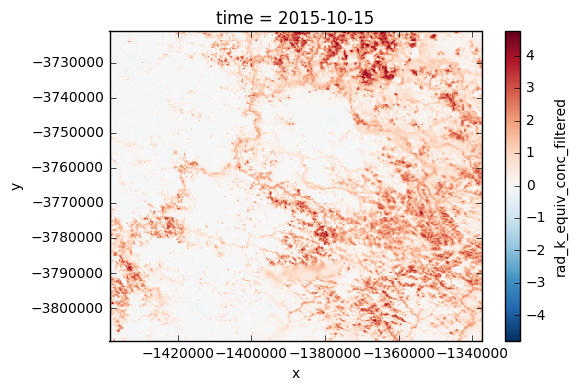

In [7]:
fig = gamma.rad_k_equiv_conc_filtered.plot()

## Apply the palaeovalley mask

In [8]:
# Read in the palaeovalley 2012 shape file
shp = gp.GeoDataFrame.from_file('/g/data/p25/cek156/Palaeovalleys_2012.shp')

# Create a bounding box from the locations specified above
box = shapely.geometry.box(names.minlon[num], names.minlat[num], names.maxlon[num], names.maxlat[num], ccw = True)
# Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
filtered = shp.where(shp.intersects(box)).dropna()
# Combine all of the relevant polygons into a single polygon
shp_union = shapely.ops.unary_union(filtered.geometry)

# Create the mask based on our shapefile
mask = geometry_mask(warp_geometry(shp_union, shp.crs, gamma.rad_k_equiv_conc_filtered.crs.wkt), gamma.rad_k_equiv_conc_filtered.geobox, invert=True)
# Get data only where the mask is 'true'
data_masked = gamma.rad_k_equiv_conc_filtered.where(mask)
# Get data only where the mask is 'false'
data_maskedF = gamma.rad_k_equiv_conc_filtered.where(~ mask)

## Now check for statistical significance
# Create a new numpy array with just the values
data_masked2 = np.array(data_masked)
data_maskedF2 = np.array(data_maskedF)
# Remove nan values
data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
masked_both = [data_masked_nonan,data_maskedF_nonan]

(array([  5.00000000e+00,   1.10000000e+01,   3.40000000e+01,
          1.30000000e+02,   7.11000000e+02,   4.12400000e+03,
          1.28400000e+04,   1.67010000e+04,   1.17760000e+04,
          7.74600000e+03,   5.81500000e+03,   4.68300000e+03,
          3.92200000e+03,   3.39400000e+03,   3.22100000e+03,
          2.92000000e+03,   2.61900000e+03,   2.43000000e+03,
          2.26500000e+03,   2.17600000e+03,   2.12500000e+03,
          1.99600000e+03,   1.89700000e+03,   1.87000000e+03,
          1.78400000e+03,   1.71200000e+03,   1.58700000e+03,
          1.53100000e+03,   1.48600000e+03,   1.36500000e+03,
          1.33700000e+03,   1.28100000e+03,   1.22600000e+03,
          1.16900000e+03,   1.04400000e+03,   1.03200000e+03,
          1.02300000e+03,   9.27000000e+02,   9.06000000e+02,
          7.73000000e+02,   7.60000000e+02,   7.21000000e+02,
          7.17000000e+02,   6.04000000e+02,   5.92000000e+02,
          4.84000000e+02,   4.70000000e+02,   4.21000000e+02,
        

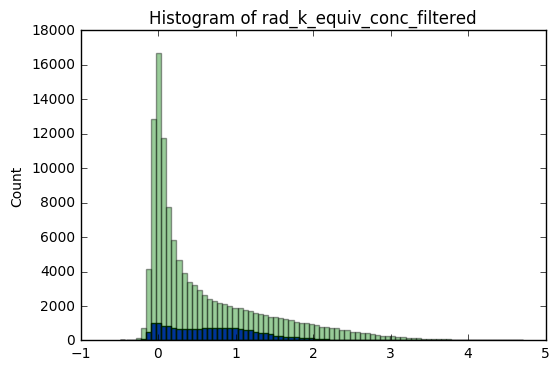

In [9]:
minval = gamma.rad_k_equiv_conc_filtered.min()
maxval = gamma.rad_k_equiv_conc_filtered.max()
bin_values = np.arange(start = minval, stop = maxval, step = ((maxval - minval)/80))
data_masked.plot.hist(bins = bin_values)
data_maskedF.plot.hist(alpha = 0.4, bins = bin_values)

## Check for statistical difference between known palaeovalleys and outside region

[array([ 0.57547104,  0.4194766 ,  0.94017404, ...,  0.73180628,
        0.59879404,  0.40902343], dtype=float32), array([-0.04104438,  0.00714516, -0.02163064, ...,  0.38737443,
        0.3821725 ,  0.85544354], dtype=float32)]
[19291, 123725]
Ttest_indResult(statistic=21.143978430205117, pvalue=4.4498127529997095e-99)
Ks_2sampResult(statistic=0.22652784051778407, pvalue=0.0)


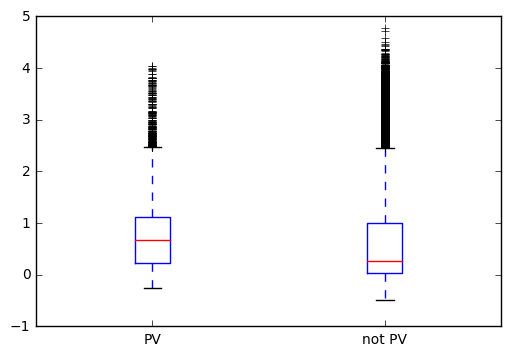

In [10]:
masked_both = [data_masked_nonan,data_maskedF_nonan]
print(masked_both)
# How many data points are in each of my lists?
size = ([len(i) for i in masked_both])
print(size)

bp = plt.boxplot(masked_both)
plt.xticks([1,2],['PV', 'not PV'])

stats_ttest = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
print(stats_ttest)

# Test with a Kolmogorov-Smirnov test 
# Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
stats_KS = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)
print(stats_KS)